---
# Lab Number : 8

## Title : *Regression with SparkMLib* 

## Background :  

Logistic regression is a popular method to predict a categorical response. 

## Goal : 

Predict if the client will subscribe (yes/no) a term deposit (variable y).

## Help:

1. Spark Programming Guide : https://spark.apache.org/docs/2.2.0/rdd-programming-guide.html
2. Spark API reference : https://spark.apache.org/docs/latest/api/python/index.html
3. Plotting reference : https://plot.ly/python/ipython-notebook-tutorial/
4. Plotting examples @ https://plot.ly/python/ipython-notebook-tutorial/#jupyter-gallery

## Datasets reference:

https://archive.ics.uci.edu/ml/datasets/bank+marketing

## Input Datasets:

* bank.csv
* bank-full.csv
* bank-additional.csv

## Datasets local path:

* /spark-course/data/bank/

---

### Working Environment Setup:
1. Check exisiting environments 
2. Activate it if already existing or create ( with !conda-env create <name> )
3. Install packages if required

In [3]:
!conda-env list

# conda environments:
#
analytics                /home/aabreu/software/anaconda3/envs/analytics
sandbox                  /home/aabreu/software/anaconda3/envs/sandbox
root                  *  /home/aabreu/software/anaconda3



In [5]:
!source activate analytics

In [11]:
!pip install seaborn

### Some Useful Functions

In [7]:
def computeHistogram(df,column_name,nbins):
    """
    Histogram computation in Spark using flatmap and histogram for the selected column of a Spark DataFrame
    :param df : a Spark DataFrame object (not a python df)
    :param column_name : the column for which histogram is to be computed
    :param nbins : the nb. of bins for data accumulation
    """
    hist = df.select(column_name).rdd.flatMap(lambda x: x).histogram(nbins)
    return hist

### Get a SparkSession object

In [4]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("LogisticRegrssion") \
    .getOrCreate()
    
print ('Spark version : ' , spark.version)

Spark version :  2.2.0


### Data Loading and Pre-Processing

In [5]:
# Load the Input Dataset into a Spark Dataframe
dataset_path='../../data/bank/'
%time df  = spark.read.option("header", "true").option("inferSchema", "true").csv(dataset_path+'bank-full.csv')
print('Number of rows in dataset : ' + str(df.count()))

CPU times: user 6 ms, sys: 0 ns, total: 6 ms
Wall time: 6.05 s
Number of rows in dataset : 41188


### Data Caching

In [6]:
df.cache()

DataFrame[age: int, job: string, marital: string, education: string, default: string, housing: string, loan: string, contact: string, month: string, day_of_week: string, duration: int, campaign: int, pdays: int, previous: int, poutcome: string, emp_var_rate: double, cons_price_idx: double, cons_conf_idx: double, euribor3m: double, nr_employed: double, y: int]

### Data Exploration

In [7]:
# What kind of attributes we have in the dataset?
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)
 |-- y: integer (nullable = true)



In [8]:
# Simple statistics on age
df.select('age').describe().show()

+-------+------------------+
|summary|               age|
+-------+------------------+
|  count|             41188|
|   mean| 40.02406040594348|
| stddev|10.421249980934071|
|    min|                17|
|    max|                98|
+-------+------------------+



In [9]:
# Simple statistics on Euribor
df.select('euribor3m').describe().show()

+-------+-----------------+
|summary|        euribor3m|
+-------+-----------------+
|  count|            41188|
|   mean|3.621290812858366|
| stddev|1.734447404851269|
|    min|            0.634|
|    max|            5.045|
+-------+-----------------+



In [21]:
# What is the mean value of number of contacts performed during this campaign for each age range
df.groupby('age').agg({'campaign': 'mean'}).show()

+---+------------------+
|age|     avg(campaign)|
+---+------------------+
| 31|2.5233692860811505|
| 85|2.2666666666666666|
| 65|1.9090909090909092|
| 53| 2.889495225102319|
| 78|1.5185185185185186|
| 34|2.4888252148997134|
| 81|               2.0|
| 28|2.3346653346653348|
| 76|               2.0|
| 27| 2.490011750881316|
| 26| 2.479942693409742|
| 44| 2.619188921859545|
| 91|               1.5|
| 22| 2.291970802919708|
| 47|2.6648706896551726|
| 52|2.6842105263157894|
| 86|               1.5|
| 40|2.6503014642549525|
| 20| 2.353846153846154|
| 94|               1.0|
+---+------------------+
only showing top 20 rows



In [ ]:
# What is the mean value of number of contacts performed during this campaign for each age range
df.groupby('age').agg({'campaign': 'mean'}).show()

In [ ]:
# Matplotlib settings

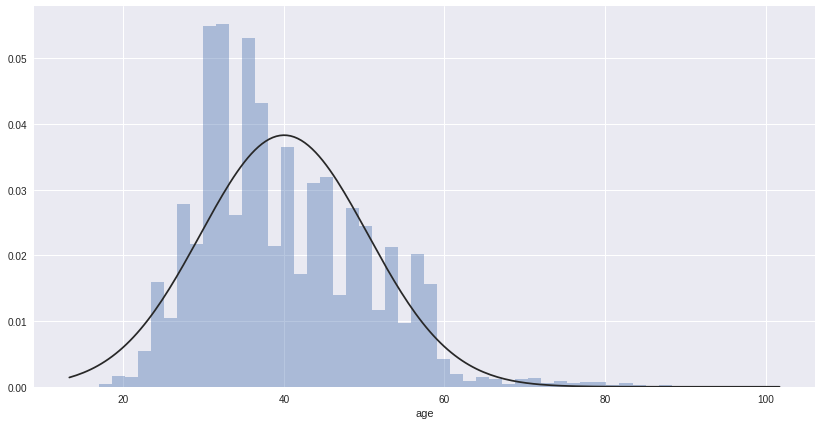

In [20]:
# Some plotting ( age distribution ? )
%matplotlib inline
import matplotlib
matplotlib.rc('figure', figsize = (14, 7))
import seaborn as sns
import numpy as np
from scipy.stats import norm
x=df.toPandas()['age']
sns.distplot(x,fit=norm, kde=False)

### Build a Model
1. We are using categorical data , so transform labels into unique indices
2. Create an RDD that contains only numeric data
3. Generate a LogisticRegression model and use it

Feature Extraction @ : https://spark.apache.org/docs/2.2.0/ml-features.html

In [43]:
# Feature Transformation (from scikit-learn)
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
# Transform the unique labelled columns into numeric values (normalized)
jobs       = df.select('job').distinct().rdd.flatMap(lambda x: x).collect()
maritals   = df.select('marital').distinct().rdd.flatMap(lambda x: x).collect()
educations = df.select('education').distinct().rdd.flatMap(lambda x: x).collect()
defaults   = df.select('default').distinct().rdd.flatMap(lambda x: x).collect()
housings   = df.select('housing').distinct().rdd.flatMap(lambda x: x).collect()
loans      = df.select('loan').distinct().rdd.flatMap(lambda x: x).collect()
months     = df.select('month').distinct().rdd.flatMap(lambda x: x).collect()
daysweek   = df.select('day_of_week').distinct().rdd.flatMap(lambda x: x).collect()
contacts   = df.select('contact').distinct().rdd.flatMap(lambda x: x).collect()

job_ids=le.fit_transform(jobs)
mrt_ids=le.fit_transform(maritals)
edu_ids=le.fit_transform(educations)
def_ids=le.fit_transform(defaults)
hou_ids=le.fit_transform(housings)
loa_ids=le.fit_transform(loans)
mon_ids=le.fit_transform(months)
day_ids=le.fit_transform(daysweek)
ctc_ids=le.fit_transform(contacts)

In [66]:
# Feature Transformation (from spark mllib)
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder

job_indexer = StringIndexer(inputCol='job', outputCol='job_id')
df1 = job_indexer.fit(df).transform(df)

mar_indexer = StringIndexer(inputCol='marital', outputCol='mar_id')
df2 = mar_indexer.fit(df1).transform(df1)

edu_indexer = StringIndexer(inputCol='education', outputCol='edu_id')
df3 = edu_indexer.fit(df2).transform(df2)

def_indexer = StringIndexer(inputCol='default', outputCol='def_id')
df4 = def_indexer.fit(df3).transform(df3)

hou_indexer = StringIndexer(inputCol='housing', outputCol='hou_id')
df5 = hou_indexer.fit(df4).transform(df4)

loa_indexer = StringIndexer(inputCol='loan', outputCol='loa_id')
df6 = loa_indexer.fit(df5).transform(df5)

mon_indexer = StringIndexer(inputCol='month', outputCol='mon_id')
df7 = mon_indexer.fit(df6).transform(df6)

dow_indexer = StringIndexer(inputCol='day_of_week', outputCol='dow_id')
df8 = dow_indexer.fit(df7).transform(df7)

con_indexer = StringIndexer(inputCol='contact', outputCol='ctc_id')
df9 = con_indexer.fit(df8).transform(df8)

out_indexer = StringIndexer(inputCol='poutcome', outputCol='out_id')
indexed     = out_indexer.fit(df9).transform(df9)

In [67]:
# For checking purposes 
indexed.select('age', 'education', 'edu_id', 'marital', 'mar_id','housing','hou_id').show(5)

+---+-----------------+------+-------+------+-------+------+
|age|        education|edu_id|marital|mar_id|housing|hou_id|
+---+-----------------+------+-------+------+-------+------+
| 44|         basic.4y|   4.0|married|   0.0|    yes|   0.0|
| 53|          unknown|   6.0|married|   0.0|     no|   1.0|
| 28|university.degree|   0.0| single|   1.0|    yes|   0.0|
| 39|      high.school|   1.0|married|   0.0|     no|   1.0|
| 55|         basic.4y|   4.0|married|   0.0|    yes|   0.0|
+---+-----------------+------+-------+------+-------+------+
only showing top 5 rows



In [69]:
# We select the numeric subset to continue
subset_df=indexed.select(\
        'age','duration','campaign','pdays','previous', \
        'job_id','mar_id','hou_id','loa_id','mon_id', \
        'dow_id','ctc_id','out_id')

In [70]:
subset_df.show(5)

+---+--------+--------+-----+--------+------+------+------+------+------+------+------+------+
|age|duration|campaign|pdays|previous|job_id|mar_id|hou_id|loa_id|mon_id|dow_id|ctc_id|out_id|
+---+--------+--------+-----+--------+------+------+------+------+------+------+------+------+
| 44|     210|       1|  999|       0|   1.0|   0.0|   0.0|   0.0|   2.0|   0.0|   0.0|   0.0|
| 53|     138|       1|  999|       0|   2.0|   0.0|   1.0|   0.0|   4.0|   4.0|   0.0|   0.0|
| 28|     339|       3|    6|       2|   4.0|   1.0|   0.0|   0.0|   3.0|   0.0|   0.0|   2.0|
| 39|     185|       2|  999|       0|   3.0|   0.0|   1.0|   0.0|   5.0|   4.0|   0.0|   0.0|
| 55|     137|       1|    3|       1|   5.0|   0.0|   0.0|   0.0|   2.0|   4.0|   0.0|   2.0|
+---+--------+--------+-----+--------+------+------+------+------+------+------+------+------+
only showing top 5 rows

